# Figure 3: 
# effect of attack models on node and edge robustness

In [26]:
import pandas as pd 
import networkx as nx
import os
import random
from random import sample

def read_graph(N):
    G = nx.Graph()
    return nx.read_gml(f'Networks/{N}.gml')

names = [ 'dolphins',
          'polbooks',
          'word_adjacencies',
          'arenas-email',
             'Karate',
             'Erdos Renyi',
             'circuits s208',
             'circuits s420',
             'circuits s838',
             'E. coli',
             'Barabasi_albert_graph',
             'facebook 0',
             'facebook 107',
             'facebook 348',
             'facebook 414',
             'facebook 686',
             'facebook 1684',
             'bn-macaque-rhesus_brain_2',
             'soc-tribes',
             'fb-pages-food',
             'bn-cat-mixed-species_brain_1',
             'soc-firm-hi-tech']


# read the networks
networks = []
for N in names:
    network = {}
    network['name'] = N
    network['graph'] = read_graph(N)
    networks.append(network)
networks

[{'name': 'dolphins',
  'path': '/dolphins/dolphins.gml',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0715b20>},
 {'name': 'polbooks',
  'path': '/polbooks/out2.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0995130>},
 {'name': 'word_adjacencies',
  'path': '/word_adjacencies.gml/word_adjacencies.gml',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0730d60>},
 {'name': 'arenas-email',
  'path': '/arenas-email/out2.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0730f70>},
 {'name': 'Karate',
  'path': 'Karate',
  'graph': <networkx.classes.graph.Graph at 0x7f629ad53190>},
 {'name': 'Erdos Renyi',
  'path': 'Erdos Renyi',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0730af0>},
 {'name': 'circuits s208',
  'path': '/circuits/s208_st.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0730490>},
 {'name': 'circuits s420',
  'path': '/circuits/s420_st.txt',
  'graph': <networkx.classes.graph.Graph at 0x7f62a0730a60>},
 {'name': 'circuits s838',
  '

In [27]:
def LCC(G):
    connected_components = list(nx.connected_components(G))
    if len(connected_components) > 0:
        subG = G.subgraph(max(connected_components, key=len))
        if len(subG.nodes())>1: 
            return subG
        else:
            return None
    else:
        # Handle the case when there are no connected components
        return None


def node_robustness(G):
    N = len(G.nodes())
    if N==0:
        return 0
    else:
        t = []
        G2 = nx.Graph()
        G2 = G.copy()
        for q in range(N):
            d = q * len(G2.nodes())
            D = random.sample(G2.nodes(), d)
            G2.remove_nodes_from(D)
            lcc = LCC(G2)
            if lcc:
                t.append(len(LCC(G2).nodes()))
        # print(t)
        return sum(t)/N

def calculate_node_robustness(graph):
    num_nodes = len(graph)
    node_robustness = 0.0

    for q in range(1, num_nodes+1):
        fraction_removed = q / num_nodes
        largest_subgraph = max(nx.connected_components(graph), key=len)
        fraction_remaining = len(largest_subgraph) / num_nodes
        node_robustness += fraction_remaining

    node_robustness /= num_nodes

    return node_robustness


def edge_robustness(G):
    E = len(G.edges())
    if E == 0:
        return 0
    else:
        t = []
        G2 = nx.Graph()
        G2 = G.copy()
        for q in range(E):
            d = q * len(G2.edges())
            D = random.sample(G2.edges(), d)
            G2.remove_edges_from(D)
            lcc = LCC(G2)
            if lcc:
                t.append(len(LCC(G2).edges()))
        # print(t)
        return sum(t)/E


In [32]:
def weighted_edges(G, C):
    '''return a weighted edges'''
    W = []
    for u,v in G.edges():
        W.append([u, v, C[u]*C[v]])
    return sorted(W, key=lambda x: x[2])

def weighted_nodes(G, C):
    '''return a weighted edges'''
    W = []
    for u in G.nodes():
        W.append([u, C[u]])
    return sorted(W, key=lambda x: x[1], reverse=True)

def batch_list(lst):
    """
    Divide a list into batches of an equal number of items (as close to 50 as possible).
    """
    batch_size = (len(lst) + 49) // 50  # Calculate the batch size
    num_batches = (len(lst) + batch_size - 1) // batch_size
    batches = [lst[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    return batches

def simulation(centr):
    results = []
    for n in networks:
        G = n['graph'].copy()
        bc_G = centr(G)
        W = weighted_nodes(G, bc_G)
        batches = batch_list(W)
        result = []
        nodess = []
        for b in range(len(batches)):
            R = [u for u,_ in batches[b]] # edges to be removed...
            G.remove_nodes_from(R)
            nodess.append(len(G.nodes()))
            r = node_robustness(G)  
            result.append([b,r] )
        results.append(result)
        print(nodess)
    return results

def plot(results, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=600)
    fig, ax = plt.subplots()
    markers = ['+', 'x', 'o', 's', 'd', 'D', '*'] # Add your desired markers here
    for d in range(len(results)):
        data = results[d]
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        marker_idx = d % len(markers) # Choose marker based on index of the result
        ax.plot(x, y, marker=markers[marker_idx], linewidth=0.5, markersize=3, label=names[d])

    ax.set_xlabel('Node Batches')
    ax.set_ylabel(r'$R_n$')
    ax.set_title(f'{title}-based node deletion')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(title+'.png', format='png', dpi=300, bbox_inches='tight')

    plt.show()


/tmp/ipykernel_24996/522223917.py:24: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  D = random.sample(G2.nodes(), d)


[60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
[186, 182, 178, 174, 170, 166, 162, 158, 154, 150, 146, 142, 138, 134, 130, 126, 122, 118, 114, 110, 106, 102, 98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2, 0]
[109, 106, 103, 100, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61, 58, 55, 52, 49, 46, 43, 40, 37, 34, 31, 28, 25, 22, 19, 16, 13, 10, 7, 4, 1, 0]
[1855, 1817, 1779, 1741, 1703, 1665, 1627, 1589, 1551, 1513, 1475, 1437, 1399, 1361, 1323, 1285, 1247, 1209, 1171, 1133, 1095, 1057, 1019, 981, 943, 905, 867, 829, 791, 753, 715, 677, 639, 601, 563, 525, 487, 449, 411, 373, 335, 297, 259, 221, 183, 145, 107, 69, 31, 0]
[33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 26

<Figure size 3840x2880 with 0 Axes>

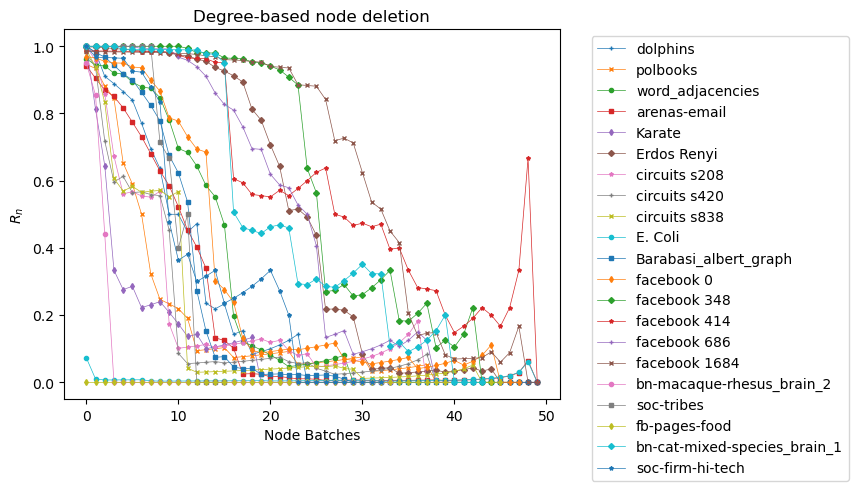

[60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
[186, 182, 178, 174, 170, 166, 162, 158, 154, 150, 146, 142, 138, 134, 130, 126, 122, 118, 114, 110, 106, 102, 98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2, 0]
[109, 106, 103, 100, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61, 58, 55, 52, 49, 46, 43, 40, 37, 34, 31, 28, 25, 22, 19, 16, 13, 10, 7, 4, 1, 0]
[1855, 1817, 1779, 1741, 1703, 1665, 1627, 1589, 1551, 1513, 1475, 1437, 1399, 1361, 1323, 1285, 1247, 1209, 1171, 1133, 1095, 1057, 1019, 981, 943, 905, 867, 829, 791, 753, 715, 677, 639, 601, 563, 525, 487, 449, 411, 373, 335, 297, 259, 221, 183, 145, 107, 69, 31, 0]
[33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 26

<Figure size 3840x2880 with 0 Axes>

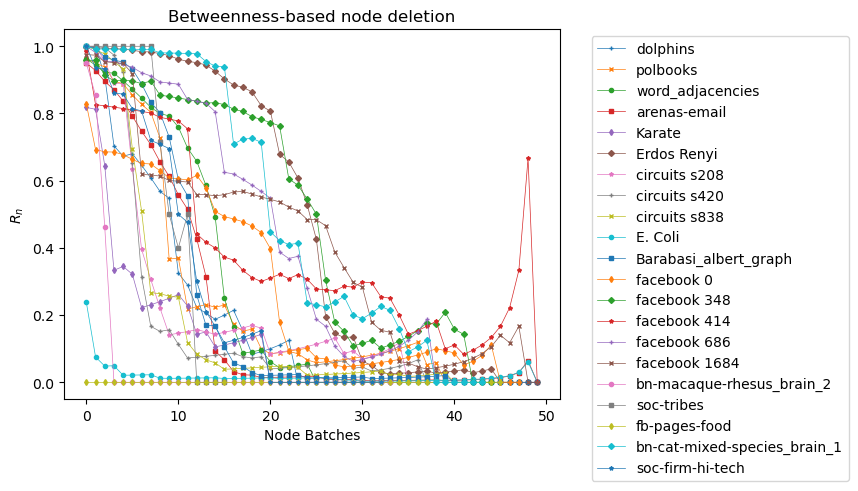

[60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
[186, 182, 178, 174, 170, 166, 162, 158, 154, 150, 146, 142, 138, 134, 130, 126, 122, 118, 114, 110, 106, 102, 98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2, 0]
[109, 106, 103, 100, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61, 58, 55, 52, 49, 46, 43, 40, 37, 34, 31, 28, 25, 22, 19, 16, 13, 10, 7, 4, 1, 0]
[1855, 1817, 1779, 1741, 1703, 1665, 1627, 1589, 1551, 1513, 1475, 1437, 1399, 1361, 1323, 1285, 1247, 1209, 1171, 1133, 1095, 1057, 1019, 981, 943, 905, 867, 829, 791, 753, 715, 677, 639, 601, 563, 525, 487, 449, 411, 373, 335, 297, 259, 221, 183, 145, 107, 69, 31, 0]
[33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 26

<Figure size 3840x2880 with 0 Axes>

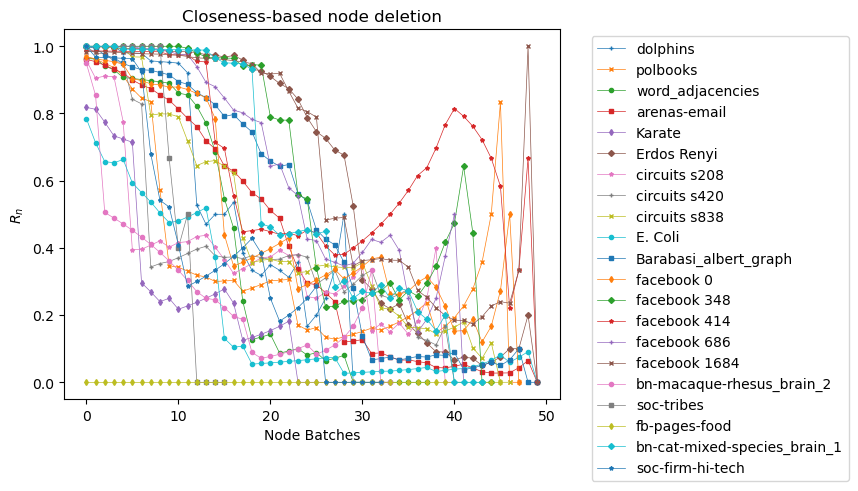

[60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
[186, 182, 178, 174, 170, 166, 162, 158, 154, 150, 146, 142, 138, 134, 130, 126, 122, 118, 114, 110, 106, 102, 98, 94, 90, 86, 82, 78, 74, 70, 66, 62, 58, 54, 50, 46, 42, 38, 34, 30, 26, 22, 18, 14, 10, 6, 2, 0]
[109, 106, 103, 100, 97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61, 58, 55, 52, 49, 46, 43, 40, 37, 34, 31, 28, 25, 22, 19, 16, 13, 10, 7, 4, 1, 0]
[1855, 1817, 1779, 1741, 1703, 1665, 1627, 1589, 1551, 1513, 1475, 1437, 1399, 1361, 1323, 1285, 1247, 1209, 1171, 1133, 1095, 1057, 1019, 981, 943, 905, 867, 829, 791, 753, 715, 677, 639, 601, 563, 525, 487, 449, 411, 373, 335, 297, 259, 221, 183, 145, 107, 69, 31, 0]
[33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 26

<Figure size 3840x2880 with 0 Axes>

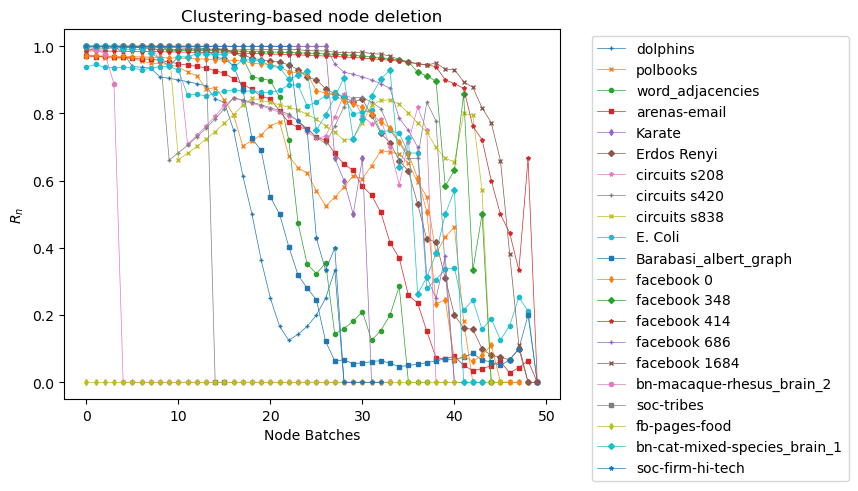

In [33]:
centralities = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality, nx.clustering]
centr        = ['Degree'            ,   'Betweenness'          ,   'Closeness'          ,   'Clustering']
for i in range(4):
    plot(simulation(centralities[i]), centr[i])